In [1]:
# Downgrade to a lower version of transformers to overcome the error
# TensorFlow and JAX classes are deprecated and
# will be removed in Transformers v5.
# We recommend migrating to PyTorch classes
# or pinning your version of Transformers.
# https://github.com/huggingface/transformers/issues/40028
# https://www.linkedin.com/pulse/hugging-face-drops-support-tensorflow-jax-revendra-t-ph-d-cppec/
# transformers<=4.54.1
!pip install transformers==4.54.1

# Does not work
# # https://stackoverflow.com/questions/78101520/valuerror-exception-encountered-when-calling-tf-distil-bert-model
# !pip uninstall -q transformers
# !pip uninstall -q sentence-transformers
# !pip install -q transformers==4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 108.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


[RIGHT GPU](https://drlee.io/choosing-the-right-colab-runtime-a-guide-for-data-scientists-and-analysts-57ee7b7c9638)

In [2]:
import transformers

print(transformers.__version__)

4.54.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import warnings
warnings.filterwarnings("ignore")
import spacy
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Distilbert Model**

In [5]:
data = pd.read_csv("/content/data/final_filtered_annotated_reviews.csv")

In [6]:
data.shape

(13594, 2)

In [7]:
data.columns

Index(['the_review', 'topics'], dtype='object')

In [8]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


In [9]:
model_data = data.copy()

In [10]:
model_data.sample(2,random_state=42)

,the_review,topics
1061,"It is a nice mouse, and I liked that it came w...",mouse
3881,Worth it,headphone


In [11]:
topics = model_data.topics.unique().tolist()
topics_mappings = {}
for index,value in enumerate(topics):
    topics_mappings[value]=index
topics_mappings

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

In [12]:
model_data['topic_label'] = model_data.topics.map(topics_mappings)

In [13]:
model_data.head()

,the_review,topics,topic_label
0,I wish I would have gotten one earlier. I love...,mouse,0
1,It is so slow and lags find a better option,mouse,0
2,Beautifully produced and lovely to look at for...,mouse,0
3,I don't typically write reviews but I keep hav...,mouse,0
4,"I bought this in late June, it looks cool with...",mouse,0


### **Downloading the Model**

In [14]:
from transformers import DistilBertTokenizer, TFDistilBertModel

In [15]:
# https://huggingface.co/distilbert/distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_uncased_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

In [16]:
distil_uncased_model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.54.1",
  "vocab_size": 30522
}

In [17]:
distil_uncased_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# https://huggingface.co/docs/transformers/v4.26.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus
# How tokenisation works
tokens = tokenizer.encode_plus(
    model_data.the_review[0],
    max_length=285,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [19]:
tokens.input_ids

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[  101,  1045,  4299,  1045,  2052,  2031,  5407,  2028,  3041,
         1012,  1045,  2293,  2009,  1998,  2009,  3084,  2551,  1999,
         2026, 12191,  2061,  2172,  6082,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [20]:
list(tokens.keys())

['input_ids', 'attention_mask']

In [21]:
tokens.attention_mask

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
tokens.input_ids.shape

TensorShape([1, 285])

In [23]:
tokens.attention_mask.shape

TensorShape([1, 285])

### **Model Training & Metrics**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,\
ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [25]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

In [26]:
y = model_data.topic_label

In [27]:
X = model_data[["the_review"]]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [29]:
tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)

In [30]:
X_train

,the_review
480,I was so excited to receive this mouse. I chos...
670,The mouse is really pretty but the battery lif...
1706,This baby is great! Works perfect with my 2020...
851,Did the job
11167,So far its been really good! The sound is very...
...,...
9776,"I think it’s good. Sound quality isn’t bad, th..."
12611,Amazing sound. I play it from the kitchen and ...
8062,Works as expected. Very comfortable. Sound qua...
3465,Have to charge it twice a day at least.It is n...


In [31]:
# Resample the training data
under_sampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [32]:
X_input_ids = np.zeros((len(X_train_resampled),285), dtype=int)
X_attention_mask = np.zeros((len(X_train_resampled),285), dtype=int)

In [33]:
print(X_input_ids[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
y_train_resampled

,topic_label
1208,0
2806,0
5020,0
6753,0
777,0
...,...
4485,2
8735,2
7415,2
10444,2


In [35]:
print(X_input_ids.shape)

(8964, 285)


In [36]:
print(X_attention_mask.shape)

(8964, 285)


In [37]:
for key,text in enumerate(X_train_resampled['the_review']):
  if key == 5:
    break
  else:
    print(text)

I just wanted a colorful mouse and this is what I expected. Its okay in ergonomics but I do not know much about ergonomics. Its okay for gaming but its not the best since its more of a office type mouse.
Great wireless mouse. Use it on my new HP stream laptop it does great. It’s light weight and easy to use. The lights on it are cool too.
Small, rechargeable and works perfectly.
For some reason I thought this took batteries but it doesnt. It has an on board battery that takes USB-c to charge. No big deal I have a note 9 and keep a charger at my desk. I got it because its waterproof and I work in a bar. Accidents happen. Haven't used that feature yet but I'll update if I do. Battery life is good. Lights look cool but you can turn them off if you want. I'd buy again.
I have been using this mouse for 5-6 weeks now and I have no complaints! It goes to sleep on its own and comes back on easily with a click. No delays or problems connecting to Bluetooth! I do wish I had a way to know what th

In [38]:
def generate_ids_masks(input_ids,attention_masks,\
                       X, tokenizer=tokenizer):
  for key, text in enumerate(X):
      tokenized_text = tokenizer.encode_plus(
                                text,
                                max_length=285,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens=True,
                                return_tensors='tf'
                            )
      input_ids[key,:] = tokenized_text.input_ids
      attention_masks[key,:] = tokenized_text.attention_mask
  return input_ids,attention_masks

In [39]:
X_input_ids,X_attention_mask = generate_ids_masks(X_input_ids,X_attention_mask,X_train_resampled['the_review'])

In [40]:
print(X_input_ids)

[[ 101 1045 2074 ...    0    0    0]
 [ 101 2307 9949 ...    0    0    0]
 [ 101 2235 1010 ...    0    0    0]
 ...
 [ 101 3129 2734 ...    0    0    0]
 [ 101 2204 2614 ...    0    0    0]
 [ 101 1045 2228 ...    0    0    0]]


In [41]:
print(X_attention_mask)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [42]:
print(X_input_ids.shape)

(8964, 285)


In [43]:
X_train_resampled.iloc[0].values

array(['I just wanted a colorful mouse and this is what I expected. Its okay in ergonomics but I do not know much about ergonomics. Its okay for gaming but its not the best since its more of a office type mouse.'],
      dtype=object)

In [44]:
print(X_input_ids[0])

[  101  1045  2074  2359  1037 14231  8000  1998  2023  2003  2054  1045
  3517  1012  2049  3100  1999  9413  7446 25524  2021  1045  2079  2025
  2113  2172  2055  9413  7446 25524  1012  2049  3100  2005 10355  2021
  2049  2025  1996  2190  2144  2049  2062  1997  1037  2436  2828  8000
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [45]:
print(X_attention_mask.shape)

(8964, 285)


In [46]:
print(X_attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [47]:
# Extracting the embeddings
def distil_bert_embeddings_extraction(model, input_ids, attention_mask):
  tf_input_ids = tf.constant(input_ids)
  tf_attention_mask = tf.constant(attention_mask)
  outputs = model({
      'input_ids': tf_input_ids,
      'attention_mask': tf_attention_mask
  })
  last_hidden_state = outputs.last_hidden_state
  mask = tf.cast(tf.expand_dims(attention_mask, -1), dtype=tf.float32)
  masked_distilbert_embeddings = last_hidden_state * mask

  # Using Mean pooling over the tokens over real tokens
  summed_distilbert_embeddings = tf.reduce_sum(masked_distilbert_embeddings, axis=1)
  counts = tf.reduce_sum(mask, axis=1)
  mean_pooled_distilbert_embeddings = summed_distilbert_embeddings / counts
  distilbert_embeddings = mean_pooled_distilbert_embeddings.numpy()
  return distilbert_embeddings

In [48]:
# Use a batch size similar to model training due to resource error given by colab
def batch_embeddings_processor(batch_size:int=128, *args):
  all_embeddings = []
  X_input_ids,X_attention_mask = args
  for i in range(0, len(X_input_ids), batch_size):
      batch_input_ids = X_input_ids[i:i + batch_size]
      batch_attention_mask = X_attention_mask[i:i + batch_size]
      batch_embeddings = distil_bert_embeddings_extraction(distil_uncased_model,
                                                           batch_input_ids,
                                                           batch_attention_mask)
      all_embeddings.append(batch_embeddings)

  final_embeddings = np.vstack(all_embeddings)
  return final_embeddings

In [ ]:
X_train_embeddings = batch_embeddings_processor(128, X_input_ids,X_attention_mask)

In [51]:
print(X_train_embeddings.shape)

(8964, 768)


In [52]:
print(X_train_embeddings[:5])

[[-0.23653774  0.0689382   0.22704132 ... -0.21449403  0.20689626
   0.29964396]
 [-0.08910216 -0.0531318   0.3443232  ... -0.18457265 -0.03179905
  -0.13819869]
 [-0.04841642 -0.1484705   0.17917477 ... -0.14042115 -0.06176636
  -0.12059703]
 [ 0.14346915  0.04549479  0.28511545 ... -0.08714207 -0.09574421
   0.03832419]
 [-0.00779299  0.09144297  0.3583185  ... -0.10908762  0.09006035
   0.22799268]]


In [53]:
y_train_resampled

,topic_label
1208,0
2806,0
5020,0
6753,0
777,0
...,...
4485,2
8735,2
7415,2
10444,2


In [59]:
lr_model = LogisticRegression(random_state=42)

In [60]:
import time
start = time.time()
lr_model.fit(X_train_embeddings,y_train_resampled)
end = time.time()
print(f" Training time: {end-start} in seconds")

 Training time: 14.26759958267212 in seconds


In [61]:
full_seconds = end - start
def convert_from_seconds(seconds):
  hours = int(seconds // 3600)
  minutes = int((seconds % 3600) // 60)
  seconds = int(seconds % 60)
  print(f"{hours} hours {minutes} minutes {seconds} seconds")
convert_from_seconds(full_seconds)

0 hours 0 minutes 14 seconds


In [62]:
y_pred_train = lr_model.predict(X_train_embeddings)

In [64]:
# Classification report train data
sns.set_theme(style="white")
def class_report_train(model_name,model,y_train_resampled,y_pred_train):
    print(classification_report(y_train_resampled,y_pred_train))
    cm = confusion_matrix(y_train_resampled,y_pred_train)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    plt.savefig(f"/content/img/train_set_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2988
           1       0.87      0.87      0.87      2988
           2       0.86      0.86      0.86      2988

    accuracy                           0.88      8964
   macro avg       0.88      0.88      0.88      8964
weighted avg       0.88      0.88      0.88      8964



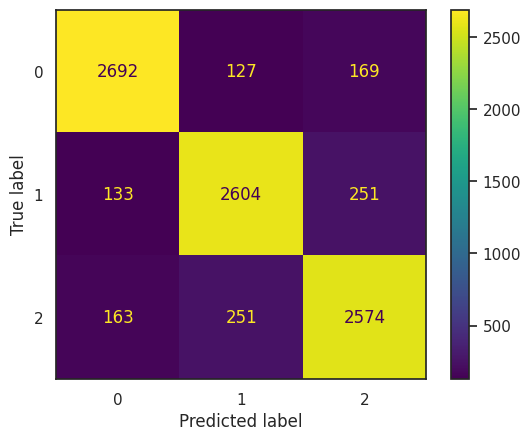

In [65]:
class_report_train('Logistic-Regression-with-DistilBert-Embeddings-Representation',lr_model,y_train_resampled,y_pred_train)

In [66]:
# https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#yellowbrick.classifier.rocauc.ROCAUC

### **Plotting the ROCAUC Curve**

(8964, 1)
(8964,)


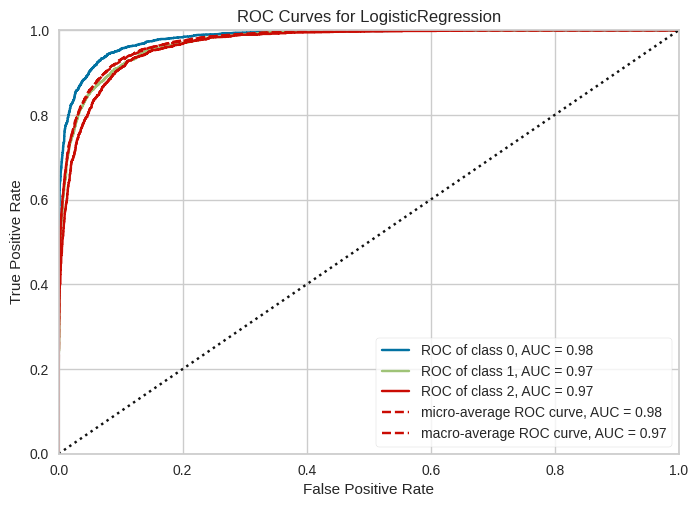

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [68]:
from yellowbrick.classifier import ROCAUC
print(X_train_resampled.shape)
print(y_train_resampled.shape)

# Plotting the curve
visualiser_train = ROCAUC(lr_model, classes=[0,1,2])

visualiser_train.fit(X_train_embeddings, y_train_resampled) # Fit the training data to the visualiser
visualiser_train.score(X_train_embeddings, y_train_resampled) # Evaluate the model on the train data
visualiser_train.show() # Finalise and show the figure

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

### **Model Test & Metrics**

In [69]:
X_test_input_ids = np.zeros((len(X_test),285), dtype = 'int')
X_test_attention_mask = np.zeros((len(X_test),285),  dtype = 'int')
X_test_input_ids,X_test_attention_mask = generate_ids_masks(X_test_input_ids,X_test_attention_mask,X_test['the_review'])
X_test_embeddings = batch_embeddings_processor(128,X_test_input_ids,X_test_attention_mask)

In [70]:
X_test_embeddings.shape

(2719, 768)

In [71]:
y_pred = lr_model.predict(X_test_embeddings)

In [72]:
# Classification report test data
sns.set_theme(style="white")
def class_report_test(model_name,model,y_test,y_pred):
    print(classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    plt.savefig(f"/content/img/test_set_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1093
           1       0.85      0.84      0.85       879
           2       0.77      0.81      0.79       747

    accuracy                           0.85      2719
   macro avg       0.84      0.84      0.84      2719
weighted avg       0.85      0.85      0.85      2719



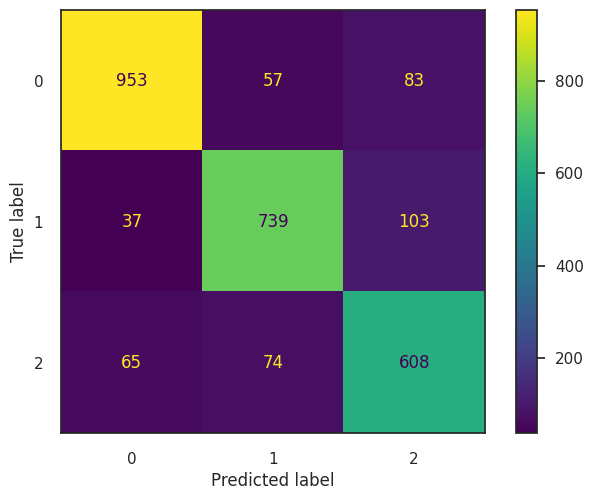

In [73]:
class_report_test("Logistic-Regression-with-DistilBert-Embeddings-Representation",lr_model,y_test,y_pred)

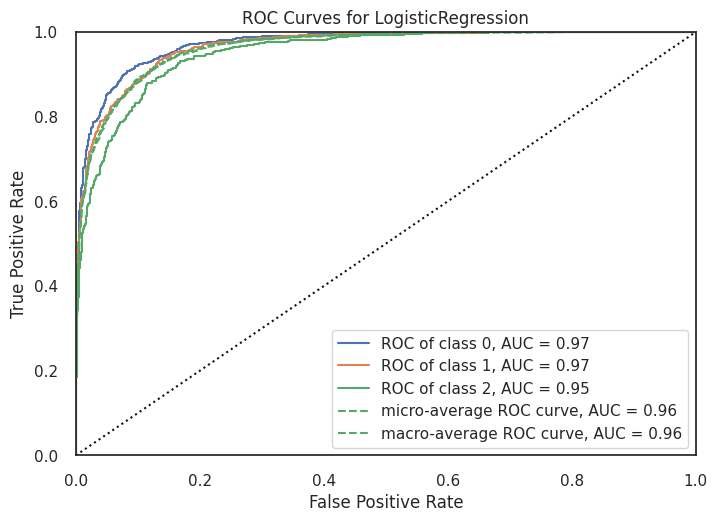

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
from yellowbrick.classifier import ROCAUC
visualiser_test = ROCAUC(lr_model, classes=[0,1,2])

visualiser_test.fit(X_train_embeddings, y_train_resampled) # Fit the training data to the visualiser
visualiser_test.score(X_test_embeddings, y_test) # Evaluate the model on the test data
visualiser_test.show() # Finalise and show the figure